In [55]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [56]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [57]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, inspect
from sqlalchemy.orm import declarative_base


In [58]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
connection = engine.connect()


In [59]:
inspector = inspect(engine)
#inspector.get_table_names()
table_names = inspector.get_table_names()

# get table names
print(f'The table names are {table_names}')





The table names are ['measurement', 'station']


In [60]:
# Get a list of column names and types
columns_measurement = inspector.get_columns('measurement')
for c in columns_measurement:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [61]:
columns_station = inspector.get_columns('station')
for c1 in columns_station:
    print(c1['name'], c1["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [62]:
# Use text construct to execute a sample query on the 'measurement' table
query = text('SELECT * FROM measurement LIMIT 5')
result = connection.execute(query).fetchall()

# Print the result
print(result)

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0), (2, 'USC00519397', '2010-01-02', 0.0, 63.0), (3, 'USC00519397', '2010-01-03', 0.0, 74.0), (4, 'USC00519397', '2010-01-04', 0.0, 76.0), (5, 'USC00519397', '2010-01-06', None, 73.0)]


In [63]:
# reflect an existing database into a new model

# reflect the tables

Base = automap_base()
Base.prepare(autoload_with=engine)



In [64]:
# View all of the classes that automap found
print(Base.classes.keys())


['measurement', 'station']


In [65]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [66]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [67]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


In [68]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= query_date).\
    order_by(measurement.date).all()





Query Date:  2016-08-23


Text(0, 0.5, 'Inches')

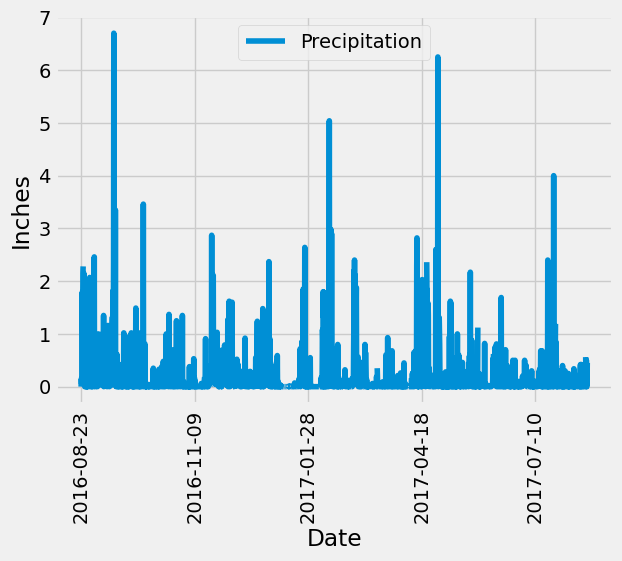

In [69]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_scores, columns=['Date', 'Precipitation'])
df.set_index(df['Date'], inplace=True)
#df.head()

df.plot(rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')


In [70]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [71]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.station.distinct())).all()

[(9,)]

In [72]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [74]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()
print(most_active_station)


[(54.0, 85.0, 71.66378066378067)]


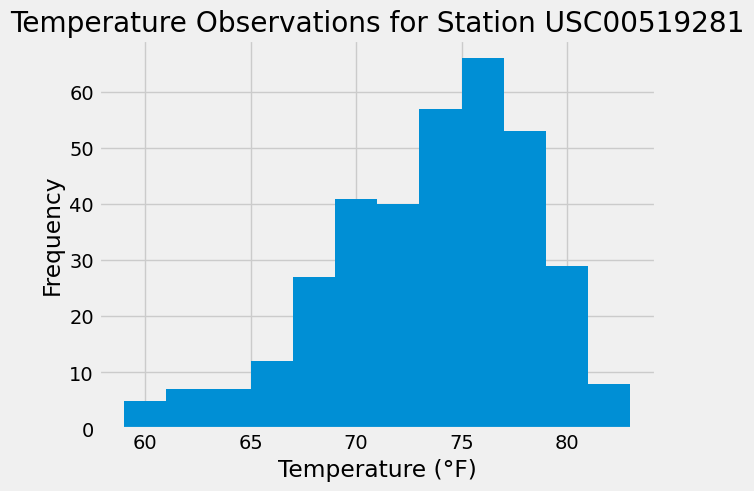

In [90]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = 'USC00519281'  

most_recent_date_station = session.query(measurement.date, measurement.tobs).\
    filter(measurement.date >= query_date).\
    filter(measurement.station == most_active_station_id).all()
#print(most_recent_date_station)

# Convert the query results to a DataFrame
df2 = pd.DataFrame(most_recent_date_station, columns=['Date', 'Temperature'])
df2.set_index(df['Temperature'], inplace=True)

# Plot the histogram
plt.hist(df2['Temperature'], bins=12)
plt.title(f'Temperature Observations for Station {most_active_station_id}')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()



# Close Session

In [91]:
# Close Session
session.close()